In [19]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# setup latex style for plots exported to svg
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# set legend text with prop={'size': 8} globally
plt.rc('legend', fontsize=8.5)


# Anti-backlash test data

In [20]:
def average_test_repetitions(df, groupby):
    data = []
    grouped = df.groupby(groupby)

    for name, group in grouped:
        group = group.drop(groupby, axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.5ms').mean()
        group = group.interpolate(method='time')
        # print(f'test {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    # print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop(groupby)
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    time_index = pd.timedelta_range(start=0, periods=min_len, freq='0.5ms')
    mean_df.index = time_index

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df


class actuator_test_data:
    def __init__(self, configuration='...'):
        self.configuration = configuration
        self.raw_torque_ramps = {}
        self.torque_ramps = {}
        self.speed_ramps = {}
        self.runin_tests = []

        
    def add_test_moment(self, phase, files):
        torque_ramp_files = [f for f in files if 'torqueramp' in f]
        speed_ramp_files = [f for f in files if 'speedramp' in f]
        
        if torque_ramp_files:
            self.add_torque_ramps(phase, torque_ramp_files)
        
        for file in speed_ramp_files:
            self.add_speed_ramp(phase, file)

    def add_torque_ramps(self, name, files):
        torque_ramps = {}
        for i, filename in enumerate(files):
            df_raw = pd.read_csv(filename)
            # print(f'{filename} loaded\t {list(df_raw.columns)}')

            df = pd.DataFrame()
            df['Time [s]'] = df_raw['TIME']
            df['Motor Torque [Nm]'] = df_raw['TORQUE']
            df['Deflection [deg]'] = df_raw['POSITION'] * 360
            df['Desired Torque [Nm]'] = df_raw['CONTROL_TORQUE']
            df['Motor Q_current [A]'] = df_raw['Q_CURRENT']
            df['test_nr'] = df_raw['test_nr']

            # print(f'Sample rate: {1/(df["Time [s]"].diff().mean())} Hz')
            df['Time [s]'] = pd.to_timedelta(df['Time [s]'], unit='s')
            df.set_index('Time [s]', inplace=True)

            self.raw_torque_ramps[name] = df

            print(f"loaded {filename}.\t Test postion: {df['Deflection [deg]'].mean():5.2f} deg")
            df['Deflection [deg]'] -= df['Deflection [deg]'].mean()
            
            TEST_NR_OFFSET = 100
            play_tests = df[df['test_nr'] < TEST_NR_OFFSET].copy()
            stiffness_tests = df[df['test_nr'] >= TEST_NR_OFFSET].copy()
            stiffness_tests['test_nr'] = stiffness_tests['test_nr'] - TEST_NR_OFFSET

            play_test_mean = average_test_repetitions(play_tests, 'test_nr')
            stiffness_test_mean = average_test_repetitions(stiffness_tests, 'test_nr')

            # shift to around 0, subtract mean
            play_test_mean['Deflection [deg]'] -= play_test_mean['Deflection [deg]'].mean()
            stiffness_test_mean['Deflection [deg]'] -= stiffness_test_mean['Deflection [deg]'].mean()

            torque_ramps[i] = (play_test_mean, stiffness_test_mean)

        test_pos = 0
        combined_play = None
        combined_stiffness = None
        for i, (play_test, stiffness_test) in torque_ramps.items():
            play_test['test_pos'] = test_pos
            stiffness_test['test_pos'] = test_pos
            test_pos += 1

            if combined_play is None:
                combined_play = play_test
                combined_stiffness = stiffness_test
            else:
                combined_play = pd.concat([combined_play, play_test])
                combined_stiffness = pd.concat([combined_stiffness, stiffness_test])

        combined_play = average_test_repetitions(combined_play, 'test_pos')
        combined_stiffness = average_test_repetitions(combined_stiffness, 'test_pos')
        combined_play['Deflection [deg]'] -= combined_play['Deflection [deg]'].mean()
        combined_stiffness['Deflection [deg]'] -= combined_stiffness['Deflection [deg]'].mean()
        torque_ramps['combined'] = (combined_play, combined_stiffness)    

        self.torque_ramps[name] = torque_ramps

    def add_speed_ramp(self, name, filename):
        df_raw = pd.read_csv(filename)

        df = pd.DataFrame()
        df['Motor Speed [rpm]'] = df_raw['VELOCITY']
        df['Motor Torque [Nm]'] = df_raw['TORQUE']
        df['Averaged Torque [Nm]'] = df['Motor Torque [Nm]'].rolling(window=500, center=True).mean()
        df['Motor Q_current [A]'] = df_raw['Q_CURRENT']

        df['Time [s]'] = pd.to_timedelta(df_raw['TIME'], unit='s')
        df.set_index('Time [s]', inplace=True)  
        
        print(f'loaded {filename}.')
        self.speed_ramps[name] = df

    def add_runin_tests(self, files):
        def read_file(filename):
            df_raw = pd.read_csv(filename, sep=';')
            
            if 'DIRECTION' not in df_raw.columns:
                # df_raw['TIME'] /= 1e9
                df_raw['DIRECTION'] = 1
            df = pd.DataFrame()
            df['Motor Torque [Nm]'] = df_raw['TORQUE']  # * df_raw['DIRECTION']
            df['Averaged Torque [Nm]'] = df['Motor Torque [Nm]'].rolling(window=100, center=True).mean()
            df['Motor Temperature [c]'] = df_raw['MOTOR_TEMPERATURE'] *0.442 - 1.62   #approximation to compensate incorrect NTC
            df['Controller Temperature [c]'] = df_raw['TEMPERATURE']
            
            df_raw['TIME'] = (df_raw['TIME'] - df_raw['TIME'].iloc[0]) / 1e9
            df['Time [s]'] = pd.to_timedelta(df_raw['TIME'], unit='s')
            df.set_index('Time [s]', inplace=True)
            
            return df

        df = read_file(files[0])
        df['test number'] = 0
        for filename in files[1:]:
            df2 = read_file(filename)
            df2.index = df2.index + df.index[-1] + pd.Timedelta(1, unit='ms')
            df2['test number'] = df['test number'].iloc[-1] + 1
            df = pd.concat([df, df2])

        print(f'loaded {len(files)} run-in tests, measured time: {df.index[-1]}')

        self.runin_tests = df

    def describe(self):
        print(f'Configuration: {self.configuration}')
        print(f'Speed ramps: {list(self.speed_ramps.keys())}')
        print(f'Torque ramps:')
        for name, ramps in self.torque_ramps.items():
            print(f'  {name}: {len(ramps)} ramps ({ramps.keys()})')
        print(f'Run-in tests: {self.runin_tests["test number"].max()+1} tests, total time: {self.runin_tests.index[-1]}')

In [21]:
tests_split_pccf_u = actuator_test_data('Split Pinwheel undersized (PC-CF)')
tests_split_pccf_u.add_test_moment('initial', [
    'test_data/2024-07-10__12-06-49_speedramp_split init_120s.csv',
    # 'test_data/2024-07-10__12-30-32__torqueramp__split init1.csv',
    'test_data/2024-07-10__12-34-04__torqueramp__split init1.csv',
    'test_data/2024-07-10__12-39-58__torqueramp__split init5.csv',
    'test_data/2024-07-10__12-45-53__torqueramp__split init6.csv', 
])
tests_split_pccf_u.add_runin_tests([
    'test_data/2024-07-10__15-56-23_run-in_split_0.35rps.csv',
])
tests_split_pccf_u.add_test_moment('after run-in', [
    'test_data/2024-07-10__16-10-16_speedramp_split 10min_120s.csv',
    'test_data/2024-07-10__16-27-11__torqueramp__split runin1.csv',
    'test_data/2024-07-10__16-31-56__torqueramp__split runin5.csv',
    'test_data/2024-07-10__16-35-37__torqueramp__split runin6.csv',
    # 'test_data/2024-07-10__16-39-51_speedramp_split runin_120s.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 1', [
    'test_data/2024-07-10__16-44-11_speedramp_split 1pre_120s.csv',
    'test_data/2024-07-10__16-48-09__torqueramp__split 1pre1.csv',
    'test_data/2024-07-10__16-52-42__torqueramp__split 1pre5.csv',
    'test_data/2024-07-10__16-58-03__torqueramp__split 1pre6.csv',
])

    # 'test_data/2024-07-11__11-11-47_speedramp_split 2pre_120s.csv',
    # 'test_data/2024-07-11__11-17-34_speedramp_split 1.5pre_120s.csv',
tests_split_pccf_u.add_test_moment('preload increase 2', [
    'test_data/2024-07-11__11-26-10_speedramp_split 2pre_120s.csv',
    'test_data/2024-07-11__11-32-34__torqueramp__split 2pre1.csv',
    'test_data/2024-07-11__11-37-19__torqueramp__split 2pre5.csv',
    'test_data/2024-07-11__11-42-35__torqueramp__split 2pre6.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 3', [
    'test_data/2024-07-11__12-18-00_speedramp_split 3pre_120s.csv',
    'test_data/2024-07-11__12-24-10__torqueramp__split 3pre1.csv',
    'test_data/2024-07-11__12-29-25__torqueramp__split 3pre5.csv',
    'test_data/2024-07-11__12-43-57__torqueramp__split 3pre6.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 4', [
    'test_data/2024-07-11__13-20-23_speedramp_split 4pre_120s.csv',
    'test_data/2024-07-11__13-26-36__torqueramp__split 4pre1.csv',
    'test_data/2024-07-11__13-42-44__torqueramp__split 4pre5.csv',
    'test_data/2024-07-11__13-46-33__torqueramp__split 4pre6.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 5', [
        'test_data/2024-07-11__13-51-30_speedramp_split 5pre_120s.csv',
])

# print('\n')
# tests_split_pccf_u.describe()

loaded test_data/2024-07-10__12-34-04__torqueramp__split init1.csv.	 Test postion: 11.16 deg
loaded test_data/2024-07-10__12-39-58__torqueramp__split init5.csv.	 Test postion: -2.97 deg
loaded test_data/2024-07-10__12-45-53__torqueramp__split init6.csv.	 Test postion:  7.38 deg
loaded test_data/2024-07-10__12-06-49_speedramp_split init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:10:12.434426100
loaded test_data/2024-07-10__16-27-11__torqueramp__split runin1.csv.	 Test postion:  3.72 deg
loaded test_data/2024-07-10__16-31-56__torqueramp__split runin5.csv.	 Test postion: -9.84 deg
loaded test_data/2024-07-10__16-35-37__torqueramp__split runin6.csv.	 Test postion:  0.26 deg
loaded test_data/2024-07-10__16-10-16_speedramp_split 10min_120s.csv.
loaded test_data/2024-07-10__16-48-09__torqueramp__split 1pre1.csv.	 Test postion:  3.91 deg
loaded test_data/2024-07-10__16-52-42__torqueramp__split 1pre5.csv.	 Test postion: -8.87 deg
loaded test_data/2024-07-10__16-58-03__torqueramp_

In [22]:
tests_base_pccf = actuator_test_data('Baseline (PC-CF)')
tests_base_pccf.add_test_moment('initial', [
    'test_data/2024-07-11__14-38-26_speedramp_base init_120s.csv',
    # 'test_data/2024-07-11__14-44-21__torqueramp__base init1.csv',
    # 'test_data/2024-07-11__14-50-03__torqueramp__base init5.csv',         # locking plate not fixed correctly
    'test_data/2024-07-11__14-54-07__torqueramp__base init1.csv',
    'test_data/2024-07-11__14-59-51__torqueramp__base init5.csv',
    'test_data/2024-07-11__15-06-17__torqueramp__base init6.csv',
])
tests_base_pccf.add_runin_tests([
    'test_data/2024-07-11__15-12-31_run-in_base_0.35rps.csv',
])
tests_base_pccf.add_test_moment('after run-in', [
    'test_data/2024-07-11__15-26-00_speedramp_base runin_120s.csv',
    'test_data/2024-07-11__15-47-12__torqueramp__base runin1.csv',
    'test_data/2024-07-11__15-51-51__torqueramp__base runin5.csv',
    'test_data/2024-07-11__15-56-27__torqueramp__base runin6.csv',
])

# print('\n')
# tests_base_pccf.describe()

loaded test_data/2024-07-11__14-54-07__torqueramp__base init1.csv.	 Test postion:  1.37 deg
loaded test_data/2024-07-11__14-59-51__torqueramp__base init5.csv.	 Test postion: -11.85 deg
loaded test_data/2024-07-11__15-06-17__torqueramp__base init6.csv.	 Test postion: -1.79 deg
loaded test_data/2024-07-11__14-38-26_speedramp_base init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:11:11.191207800
loaded test_data/2024-07-11__15-47-12__torqueramp__base runin1.csv.	 Test postion:  1.58 deg
loaded test_data/2024-07-11__15-51-51__torqueramp__base runin5.csv.	 Test postion: -12.11 deg
loaded test_data/2024-07-11__15-56-27__torqueramp__base runin6.csv.	 Test postion: -1.66 deg
loaded test_data/2024-07-11__15-26-00_speedramp_base runin_120s.csv.


In [23]:
tests_conic_pccf = actuator_test_data('Conic Disk (PC-CF)')
tests_conic_pccf.add_test_moment('initial', [
    'test_data/2024-07-12__11-25-30_speedramp_conic init_120s.csv',
    'test_data/2024-07-12__11-33-31__torqueramp__conic init1.csv', 
    'test_data/2024-07-12__12-23-01__torqueramp__conic init5.csv',
    'test_data/2024-07-12__12-29-20__torqueramp__conic init6.csv',
])
tests_conic_pccf.add_runin_tests([
    'test_data/2024-07-12__12-40-29_run-in_conic_0.35rps.csv',
    'test_data/2024-07-12__12-55-01_run-in_conic_0.35rps.csv',
])
tests_conic_pccf.add_test_moment('after run-in', [
    'test_data/2024-07-12__12-57-37_speedramp_conic runin_120s.csv',
    'test_data/2024-07-12__13-05-47__torqueramp__conic runin1.csv',
    'test_data/2024-07-12__13-16-01__torqueramp__conic runin5.csv',
    'test_data/2024-07-12__13-32-22__torqueramp__conic runin6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 1', [
    'test_data/2024-07-12__13-58-40_speedramp_conic 1pre_120s.csv',
    'test_data/2024-07-12__14-07-48__torqueramp__conic 1pre1.csv',
    'test_data/2024-07-12__14-26-23__torqueramp__conic 1pre5.csv',
    'test_data/2024-07-12__14-31-48__torqueramp__conic 1pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 2', [
    'test_data/2024-07-12__14-45-16_speedramp_conic 2pre_120s.csv',
    'test_data/2024-07-12__14-52-50__torqueramp__conic 2pre1.csv',
    'test_data/2024-07-12__14-57-29__torqueramp__conic 2pre5.csv',
    'test_data/2024-07-12__15-12-22__torqueramp__conic 2pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 3', [
    'test_data/2024-07-12__16-18-48_speedramp_conic 3pre_120s.csv',
    'test_data/2024-07-12__16-23-23__torqueramp__conic 3pre1.csv',
    'test_data/2024-07-12__16-34-37__torqueramp__conic 3pre5.csv',
    'test_data/2024-07-12__16-28-44__torqueramp__conic 3pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 4', [
    'test_data/2024-07-12__16-41-31_speedramp_conic 4pre_120s.csv',
    'test_data/2024-07-12__16-46-43__torqueramp__conic 4pre1.csv',
    'test_data/2024-07-12__16-57-04__torqueramp__conic 4pre5.csv',
    'test_data/2024-07-12__16-51-38__torqueramp__conic 4pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 5', [
    'test_data/2024-07-12__17-03-46_speedramp_conic 5pre_120s.csv',
    'test_data/2024-07-12__17-09-01__torqueramp__conic 5pre1.csv',
    'test_data/2024-07-12__17-17-36__torqueramp__conic 5pre5.csv', 
    'test_data/2024-07-12__17-13-06__torqueramp__conic 5pre6.csv',
])

# print('\n')
# tests_conic_pccf.describe()

loaded test_data/2024-07-12__11-33-31__torqueramp__conic init1.csv.	 Test postion:  6.46 deg
loaded test_data/2024-07-12__12-23-01__torqueramp__conic init5.csv.	 Test postion: -8.41 deg
loaded test_data/2024-07-12__12-29-20__torqueramp__conic init6.csv.	 Test postion:  1.71 deg
loaded test_data/2024-07-12__11-25-30_speedramp_conic init_120s.csv.
loaded 2 run-in tests, measured time: 0 days 00:12:27.924977900
loaded test_data/2024-07-12__13-05-47__torqueramp__conic runin1.csv.	 Test postion:  5.06 deg
loaded test_data/2024-07-12__13-16-01__torqueramp__conic runin5.csv.	 Test postion: -7.95 deg
loaded test_data/2024-07-12__13-32-22__torqueramp__conic runin6.csv.	 Test postion:  2.47 deg
loaded test_data/2024-07-12__12-57-37_speedramp_conic runin_120s.csv.
loaded test_data/2024-07-12__14-07-48__torqueramp__conic 1pre1.csv.	 Test postion:  5.70 deg
loaded test_data/2024-07-12__14-26-23__torqueramp__conic 1pre5.csv.	 Test postion: -8.12 deg
loaded test_data/2024-07-12__14-31-48__torqueramp_

In [24]:
tests_split_pccf = actuator_test_data('Split Pinwheel (PC-CF)') 
tests_split_pccf.add_test_moment('initial', [
    'test_data/2024-07-15__14-09-03_speedramp_split init_120s.csv',
    'test_data/2024-07-15__14-17-32__torqueramp__split init1.csv',
    'test_data/2024-07-15__14-26-05__torqueramp__split init5.csv',
    'test_data/2024-07-15__14-35-07__torqueramp__split init6.csv',
])
tests_split_pccf.add_runin_tests([
    'test_data/2024-07-15__14-49-39_run-in_split_0.35rps.csv',
])
# tests_split_pccf.add_test_moment('after run-in bad', [
#     # 'test_data/2024-07-15__15-39-03_speedramp_split runin_120s.csv',  #bad data
#     'test_data/2024-07-15__16-49-37_speedramp_split runin_120s.csv',  # also bad data
#     'test_data/2024-07-15__15-46-08__torqueramp__split runin1.csv',
#     'test_data/2024-07-15__15-50-46__torqueramp__split runin5.csv',
#     'test_data/2024-07-15__15-56-24__torqueramp__split runin6.csv',
# ])
# tests_split_pccf.add_test_moment('after run-in', [
#     'test_data/2024-07-16__15-38-03_speedramp_split_pccf runin_120s.csv',
#     'test_data/2024-07-16__15-52-19__torqueramp__split_pccf runin1.csv',     #### started to lock up 
#     '',
#     '',
# ])

# reassembled making sure all preload screw set equally. motor recalibrated so changed angles
tests_split_pccf.add_test_moment('after run-in (and reassembled)', [
    'test_data/2024-07-17__13-23-30_speedramp_split_pccf runin reassembly_120s.csv',
    'test_data/2024-07-17__13-32-02__torqueramp__split reas1.csv',
    'test_data/2024-07-17__13-41-31__torqueramp__split reas6.csv',
    'test_data/2024-07-17__13-36-10__torqueramp__split reas5.csv',
])
tests_split_pccf.add_test_moment('preload increase 1', [
    'test_data/2024-07-17__13-52-38_speedramp_split 1pre_120s.csv',
    'test_data/2024-07-17__13-57-05__torqueramp__split 1pre1.csv',
    'test_data/2024-07-17__14-07-11__torqueramp__split 1pre5.csv',
    'test_data/2024-07-17__14-12-54__torqueramp__split 1pre6.csv',
])
tests_split_pccf.add_test_moment('preload increase 2', [
    'test_data/2024-07-17__14-20-20_speedramp_split 2pre_120s.csv',
    'test_data/2024-07-17__14-25-16__torqueramp__split 2pre1.csv',
    'test_data/2024-07-17__14-30-20__torqueramp__split 2pre5.csv',
    'test_data/2024-07-17__14-35-53__torqueramp__2pre6.csv',
])
tests_split_pccf.add_test_moment('preload increase 3', [
    'test_data/2024-07-17__14-48-51_speedramp_split 3pre_120s.csv',
    'test_data/2024-07-17__14-55-39__torqueramp__split 3pre1.csv',
    'test_data/2024-07-17__15-04-06__torqueramp__split 3pre5.csv',
    'test_data/2024-07-17__15-14-30__torqueramp__split 3pre6.csv',
])


loaded test_data/2024-07-15__14-17-32__torqueramp__split init1.csv.	 Test postion: -9.98 deg
loaded test_data/2024-07-15__14-26-05__torqueramp__split init5.csv.	 Test postion:  3.55 deg
loaded test_data/2024-07-15__14-35-07__torqueramp__split init6.csv.	 Test postion: -13.53 deg
loaded test_data/2024-07-15__14-09-03_speedramp_split init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:19:03.936562800
loaded test_data/2024-07-17__13-32-02__torqueramp__split reas1.csv.	 Test postion: -10.25 deg
loaded test_data/2024-07-17__13-41-31__torqueramp__split reas6.csv.	 Test postion: 13.32 deg
loaded test_data/2024-07-17__13-36-10__torqueramp__split reas5.csv.	 Test postion:  3.64 deg
loaded test_data/2024-07-17__13-23-30_speedramp_split_pccf runin reassembly_120s.csv.
loaded test_data/2024-07-17__13-57-05__torqueramp__split 1pre1.csv.	 Test postion: -10.39 deg
loaded test_data/2024-07-17__14-07-11__torqueramp__split 1pre5.csv.	 Test postion:  3.69 deg
loaded test_data/2024-07-17__14-12

In [25]:
tests_base_910 = actuator_test_data('Baseline (Alloy 910)')
tests_base_910.add_test_moment('initial - unreamed', [
    # 'test_data/2024-07-15__16-28-49_speedramp_base910 unreamed init_120s.csv',
    'test_data/2024-07-15__16-56-07_speedramp_base910_unr init_120s.csv', 
    # 'test_data/2024-07-16__10-52-10__torqueramp__base910_unr init1.csv', 
    'test_data/2024-07-16__10-53-56__torqueramp__base910_unr init1.csv', 
    'test_data/2024-07-16__11-00-31__torqueramp__base910_unr init5.csv', 
    'test_data/2024-07-16__11-05-14__torqueramp__base910_unr init6.csv', 
])
tests_base_910.add_runin_tests([
    'test_data/2024-07-16__11-14-02_run-in_base910_unr_0.35rps.csv',
])
tests_base_910.add_test_moment('after run-in warm', [
    'test_data/2024-07-16__12-16-46_speedramp_base910_unr runin_120s.csv',
    'test_data/2024-07-16__11-55-30__torqueramp__base910_unr runin1.csv',
    'test_data/2024-07-16__12-03-12__torqueramp__base910_unr runin5.csv',
    'test_data/2024-07-16__12-11-39__torqueramp__base910_unr runin6.csv',
])
tests_base_910.add_test_moment('after run-in cold', [
    'test_data/2024-07-16__15-45-29_speedramp_base910_unr cold_120s.csv',
    'test_data/2024-07-16__14-23-33__torqueramp__base910_unr cold6.csv', 
    'test_data/2024-07-16__14-12-42__torqueramp__base910_unr cold5.csv',
    'test_data/2024-07-16__13-59-43__torqueramp__base910_unr cold1.csv',
])
tests_base_910.add_test_moment('after reaming output holes', [
    'test_data/2024-07-17__12-17-34_speedramp_base910_reamed_120s.csv',
    'test_data/2024-07-17__12-24-38__torqueramp__base910 reamed1.csv',
    'test_data/2024-07-17__12-40-35__torqueramp__base910 reamed5.csv',
    'test_data/2024-07-17__12-45-13__torqueramp__base910 reamed6.csv',
])


loaded test_data/2024-07-16__10-53-56__torqueramp__base910_unr init1.csv.	 Test postion:  9.01 deg
loaded test_data/2024-07-16__11-00-31__torqueramp__base910_unr init5.csv.	 Test postion: -4.81 deg
loaded test_data/2024-07-16__11-05-14__torqueramp__base910_unr init6.csv.	 Test postion:  5.32 deg
loaded test_data/2024-07-15__16-56-07_speedramp_base910_unr init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:31:19.833365400
loaded test_data/2024-07-16__11-55-30__torqueramp__base910_unr runin1.csv.	 Test postion:  9.55 deg
loaded test_data/2024-07-16__12-03-12__torqueramp__base910_unr runin5.csv.	 Test postion: -4.07 deg
loaded test_data/2024-07-16__12-11-39__torqueramp__base910_unr runin6.csv.	 Test postion:  4.95 deg
loaded test_data/2024-07-16__12-16-46_speedramp_base910_unr runin_120s.csv.
loaded test_data/2024-07-16__14-23-33__torqueramp__base910_unr cold6.csv.	 Test postion:  4.78 deg
loaded test_data/2024-07-16__14-12-42__torqueramp__base910_unr cold5.csv.	 Test postion: 

In [26]:
tests_base_onyx = actuator_test_data('Baseline (Onyx)')
tests_base_onyx.add_test_moment('initial', [
    'test_data/2024-07-17__15-43-43_speedramp_base_onyx init_120s.csv', 
    'test_data/2024-07-17__15-49-43__torqueramp__base_onyx init1.csv',
    'test_data/2024-07-17__15-54-23__torqueramp__base_onyx init5.csv',
    'test_data/2024-07-17__15-58-39__torqueramp__base_onyx init6.csv'
])
tests_base_onyx.add_runin_tests([
    'test_data/2024-07-17__16-00-53_run-in_base_onyx_0.35rps.csv',
])
tests_base_onyx.add_test_moment('after run-in', [
    'test_data/2024-07-18__10-35-38_speedramp_base_onyx runin_120s.csv',
    'test_data/2024-07-18__10-58-26__torqueramp__base_onyx runin1.csv',
    'test_data/2024-07-18__11-02-28__torqueramp__base_onyx runin5.csv',
    'test_data/2024-07-18__11-17-26__torqueramp__base_onyx runin6.csv',
])

# tests_base_onyx.describe()
# tests_base_onyx.runin_tests.plot(y=['Motor Torque [Nm]', 'Averaged Torque [Nm]'], secondary_y=['Motor Temperature [c]', 'Controller Temperature'], figsize=(10, 5))
# tests_base_onyx.runin_tests

loaded test_data/2024-07-17__15-49-43__torqueramp__base_onyx init1.csv.	 Test postion: -1.46 deg
loaded test_data/2024-07-17__15-54-23__torqueramp__base_onyx init5.csv.	 Test postion: 12.40 deg
loaded test_data/2024-07-17__15-58-39__torqueramp__base_onyx init6.csv.	 Test postion: -4.90 deg
loaded test_data/2024-07-17__15-43-43_speedramp_base_onyx init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 01:20:49.309733900
loaded test_data/2024-07-18__10-58-26__torqueramp__base_onyx runin1.csv.	 Test postion: -1.52 deg
loaded test_data/2024-07-18__11-02-28__torqueramp__base_onyx runin5.csv.	 Test postion: 11.76 deg
loaded test_data/2024-07-18__11-17-26__torqueramp__base_onyx runin6.csv.	 Test postion: -5.05 deg
loaded test_data/2024-07-18__10-35-38_speedramp_base_onyx runin_120s.csv.


In [27]:
tests_split_onyx = actuator_test_data('Split Pinwheel (Onyx)')
tests_split_onyx.add_test_moment('initial', [
    'test_data/2024-07-18__12-04-16_speedramp_split_onyx init_120s.csv',
    'test_data/2024-07-18__12-13-03__torqueramp__split_onyx init1.csv',
    'test_data/2024-07-18__12-22-04__torqueramp__split_onyx init5.csv',
    'test_data/2024-07-18__12-26-01__torqueramp__split_onyx init6.csv',
])
tests_split_onyx.add_runin_tests([
    'test_data/2024-07-18__12-32-09_run-in_split_onyx_0.35rps.csv',
])
tests_split_onyx.add_test_moment('after run-in', [
    'test_data/2024-07-18__16-21-56_speedramp_split_onyx runin_120s.csv',
    'test_data/2024-07-18__16-28-57__torqueramp__split_onyx runin1.csv',
    'test_data/2024-07-18__16-32-24__torqueramp__split_onyx runin5.csv',
    'test_data/2024-07-18__16-49-32__torqueramp__split_onyx runin6.csv',
])
tests_split_onyx.add_test_moment('preload increase 1', [
    'test_data/2024-07-18__16-54-19_speedramp_split_onyx 1pre_120s.csv',
    'test_data/2024-07-18__16-58-28__torqueramp__split_onyx 1pre1.csv',
    'test_data/2024-07-18__17-03-34__torqueramp__split_onyx 1pre5.csv',
    'test_data/2024-07-18__17-08-06__torqueramp__split_onyx 1pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 2', [
    # 'test_data/2024-07-18__17-13-19_speedramp_split_onyx 2pre_120s.csv',
    'test_data/2024-07-18__17-16-14_speedramp_split_onyx 2pre redo_120s.csv',
    'test_data/2024-07-18__17-20-15__torqueramp__split_onyx 2pre1.csv',
    'test_data/2024-07-18__17-23-41__torqueramp__split_onyx 2pre5.csv',
    'test_data/2024-07-18__17-26-47__torqueramp__split_onyx 2pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 3', [
    'test_data/2024-07-18__17-32-11_speedramp_split_onyx 3pre_120s.csv',
    'test_data/2024-07-18__17-36-03__torqueramp__split_onyx 3pre1.csv',
    'test_data/2024-07-18__17-40-43__torqueramp__split_onyx 3pre5.csv',
    'test_data/2024-07-18__17-45-38__torqueramp__split_onyx 3pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 4', [
    'test_data/2024-07-18__17-54-06_speedramp_split_onyx 4pre_120s.csv',
    'test_data/2024-07-18__18-00-07__torqueramp__split_onyx 4pre1.csv',
    'test_data/2024-07-18__18-03-49__torqueramp__split_onyx 4pre5.csv',
    'test_data/2024-07-18__18-06-57__torqueramp__split_onyx 4pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 5', [
    'test_data/2024-07-18__18-11-55_speedramp_split_onyx 5pre_120s.csv',
    'test_data/2024-07-18__18-15-26__torqueramp__split_onyx 5pre1.csv',
    'test_data/2024-07-18__18-18-30__torqueramp__split_onyx 5pre5.csv',
    'test_data/2024-07-18__18-21-33__torqueramp__split_onyx 5pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 6', [
    'test_data/2024-07-18__18-26-39_speedramp_split_onyx 6pre_120s.csv',
    'test_data/2024-07-18__18-30-11__torqueramp__split_onyx 6pre1.csv',
    'test_data/2024-07-18__18-33-20__torqueramp__split_onyx 6pre5.csv',
    'test_data/2024-07-18__18-36-30__torqueramp__split_onyx 6pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 7', [
    'test_data/2024-07-19__11-14-16_speedramp_split_onyx 7pre_120s.csv',
    'test_data/2024-07-19__11-18-58__torqueramp__split_onyx 7pre1.csv',
    'test_data/2024-07-19__11-22-18__torqueramp__split_onyx 7pre5.csv',
    'test_data/2024-07-19__11-25-41__torqueramp__split_onyx 7pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 8', [
    'test_data/2024-07-19__11-30-13_speedramp_split_onyx 8pre_120s.csv',
    'test_data/2024-07-19__11-35-25__torqueramp__split_onyx 8pre1.csv',
    'test_data/2024-07-19__11-38-44__torqueramp__split_onyx 8pre5.csv',
    'test_data/2024-07-19__11-41-55__torqueramp__split_onyx 8pre6.csv',
])
# tests_split_onyx.add_test_moment('preload increase 9', [
#     'test_data/2024-07-19__11-48-19_speedramp_split_onyx 9pre_120s.csv',
#     'test_data/2024-07-19__11-52-46__torqueramp__split_onyx 9pre1.csv',
#     'test_data/2024-07-19__11-56-19__torqueramp__split_onyx 9pre5.csv',
#     'test_data/2024-07-19__11-59-31__torqueramp__split_onyx 9pre6.csv',
# ])
# tests_split_onyx.add_test_moment('preload increase 10', [
#     'test_data/2024-07-19__12-05-03_speedramp_split_onyx 10pre_120s.csv',
#     'test_data/2024-07-19__12-13-32__torqueramp__split_onyx 10pre1.csv',
#     'test_data/2024-07-19__12-17-03__torqueramp__split_onyx 10pre5.csv',
#     'test_data/2024-07-19__12-10-03__torqueramp__split_onyx 10pre6.csv',
# ])
# tests_split_onyx.add_test_moment('preload increase 11', [
#     'test_data/2024-07-19__12-21-39_speedramp_split_onyx 11pre_120s.csv',
#     'test_data/2024-07-19__12-25-42__torqueramp__split_onyx 11pre1.csv',
#     'test_data/2024-07-19__12-30-41__torqueramp__split_onyx 11pre5.csv',
#     'test_data/2024-07-19__12-36-11__torqueramp__split_onyx 11pre6.csv',
# ])
# tests_split_onyx.add_test_moment('preload increase 12', [
#     'test_data/2024-07-19__12-42-30_speedramp_split_onyx 12pre_120s.csv',
#     'test_data/2024-07-19__12-45-43__torqueramp__split_onyx 12pre1.csv',
#     'test_data/2024-07-19__12-49-55__torqueramp__split_onyx 12pre5.csv',
#     'test_data/2024-07-19__12-54-36__torqueramp__split_onyx 12pre6.csv',
# ])

# tests_split_onyx.describe()


loaded test_data/2024-07-18__12-13-03__torqueramp__split_onyx init1.csv.	 Test postion: -1.95 deg
loaded test_data/2024-07-18__12-22-04__torqueramp__split_onyx init5.csv.	 Test postion: 11.95 deg
loaded test_data/2024-07-18__12-26-01__torqueramp__split_onyx init6.csv.	 Test postion: -5.83 deg
loaded test_data/2024-07-18__12-04-16_speedramp_split_onyx init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 01:28:14.930357600
loaded test_data/2024-07-18__16-28-57__torqueramp__split_onyx runin1.csv.	 Test postion: -1.50 deg
loaded test_data/2024-07-18__16-32-24__torqueramp__split_onyx runin5.csv.	 Test postion: 11.79 deg
loaded test_data/2024-07-18__16-49-32__torqueramp__split_onyx runin6.csv.	 Test postion: -5.66 deg
loaded test_data/2024-07-18__16-21-56_speedramp_split_onyx runin_120s.csv.
loaded test_data/2024-07-18__16-58-28__torqueramp__split_onyx 1pre1.csv.	 Test postion: -3.02 deg
loaded test_data/2024-07-18__17-03-34__torqueramp__split_onyx 1pre5.csv.	 Test postion: 11.13 deg


In [28]:
tests_conic_onyx = actuator_test_data('Conic Disk (Onyx)')
tests_conic_onyx.add_test_moment('initial', [
    # 'test_data/2024-07-18__14-16-00_speedramp_cone_onyx init_120s.csv',
    'test_data/2024-07-18__14-18-36_speedramp_conic_onyx init_120s.csv',
    'test_data/2024-07-18__14-28-32__torqueramp__conic_onyx init1.csv',
    'test_data/2024-07-18__14-38-06__torqueramp__conic_onyx init5.csv',
    'test_data/2024-07-18__14-43-54__torqueramp__conic_onyx init6.csv',
])
tests_conic_onyx.add_runin_tests([
    'test_data/2024-07-18__14-46-11_run-in_conic_onyx_0.35rps.csv',
])
tests_conic_onyx.add_test_moment('after run-in', [
    'test_data/2024-07-19__13-01-08_speedramp_conic_onyx runin_120s.csv',
    # 'test_data/2024-07-19__13-05-35__torqueramp__conic_onyx runin1.csv',
    'test_data/2024-07-19__13-07-36__torqueramp__conic_onyx runin1.csv',
    'test_data/2024-07-19__13-10-53__torqueramp__conic_onyx runin5.csv',
    'test_data/2024-07-19__13-15-33__torqueramp__conic_onyx runin6.csv',
])
tests_conic_onyx.add_test_moment('preload increase 1', [
    'test_data/2024-07-19__13-22-07_speedramp_conic_onyx 1pre_120s.csv',
    'test_data/2024-07-19__13-27-30__torqueramp__conic_onyx 1pre1.csv',
    'test_data/2024-07-19__13-30-53__torqueramp__conic_onyx 1pre1.csv',
    'test_data/2024-07-19__13-37-48__torqueramp__conic_onyx 1pre5.csv',
    'test_data/2024-07-19__13-43-25__torqueramp__conic_onyx 1pre6.csv',
])
tests_conic_onyx.add_test_moment('preload increase 2', [
    'test_data/2024-07-19__13-49-49_speedramp_conic_onyx 2pre_120s.csv',
    'test_data/2024-07-19__13-53-23__torqueramp__conic_onyx 2pre1.csv',
    'test_data/2024-07-19__13-57-00__torqueramp__conic_onyx 2pre5.csv',
    'test_data/2024-07-19__14-00-00__torqueramp__conic_onyx 2pre6.csv',
])
tests_conic_onyx.add_test_moment('preload increase 3', [
    'test_data/2024-07-19__14-06-46_speedramp_conic_onyx 3pre_120s.csv',
    'test_data/2024-07-19__14-10-07__torqueramp__conic_onyx 3pre1.csv',
    'test_data/2024-07-19__14-13-41__torqueramp__conic_onyx 3pre5.csv',
    'test_data/2024-07-19__14-18-09__torqueramp__conic_onyx 3pre6.csv',
])
tests_conic_onyx.add_test_moment('preload increase 4', [
    'test_data/2024-07-19__14-23-33_speedramp_conic_onyx 4pre_120s.csv',
    'test_data/2024-07-19__14-28-09__torqueramp__conic_onyx 4pre1.csv',
    'test_data/2024-07-19__14-36-36__torqueramp__conic_onyx 4pre5.csv',
    'test_data/2024-07-19__14-40-25__torqueramp__conic_onyx 4pre6.csv',
])
# tests_conic_onyx.add_test_moment('preload increase 5', [
#     'test_data/2024-07-19__14-48-41_speedramp_conic_onyx 5pre_120s.csv',
#     'test_data/2024-07-19__14-53-13__torqueramp__conic_onyx 5pre1.csv',
#     'test_data/2024-07-19__14-56-49__torqueramp__conic_onyx 5pre5.csv',
#     'test_data/2024-07-19__15-00-38__torqueramp__conic_onyx 5pre6.csv',
# ])


# tests_conic_onyx.describe()

loaded test_data/2024-07-18__14-28-32__torqueramp__conic_onyx init1.csv.	 Test postion:  2.22 deg
loaded test_data/2024-07-18__14-38-06__torqueramp__conic_onyx init5.csv.	 Test postion: -11.06 deg
loaded test_data/2024-07-18__14-43-54__torqueramp__conic_onyx init6.csv.	 Test postion: -0.69 deg
loaded test_data/2024-07-18__14-18-36_speedramp_conic_onyx init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 01:31:50.694483500
loaded test_data/2024-07-19__13-07-36__torqueramp__conic_onyx runin1.csv.	 Test postion:  1.37 deg
loaded test_data/2024-07-19__13-10-53__torqueramp__conic_onyx runin5.csv.	 Test postion: -11.56 deg
loaded test_data/2024-07-19__13-15-33__torqueramp__conic_onyx runin6.csv.	 Test postion: -0.88 deg
loaded test_data/2024-07-19__13-01-08_speedramp_conic_onyx runin_120s.csv.
loaded test_data/2024-07-19__13-27-30__torqueramp__conic_onyx 1pre1.csv.	 Test postion:  2.31 deg
loaded test_data/2024-07-19__13-30-53__torqueramp__conic_onyx 1pre1.csv.	 Test postion:  1.55 de

# data visualization

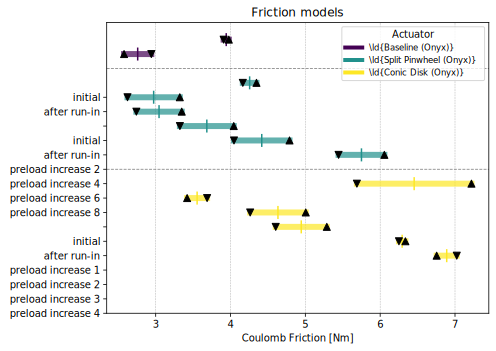

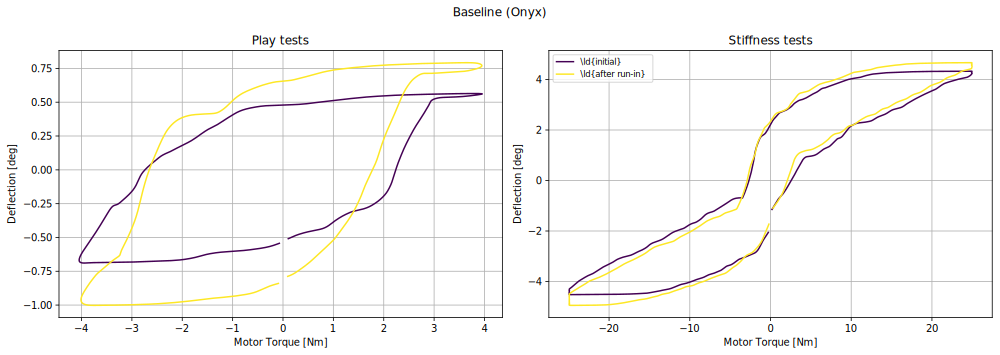

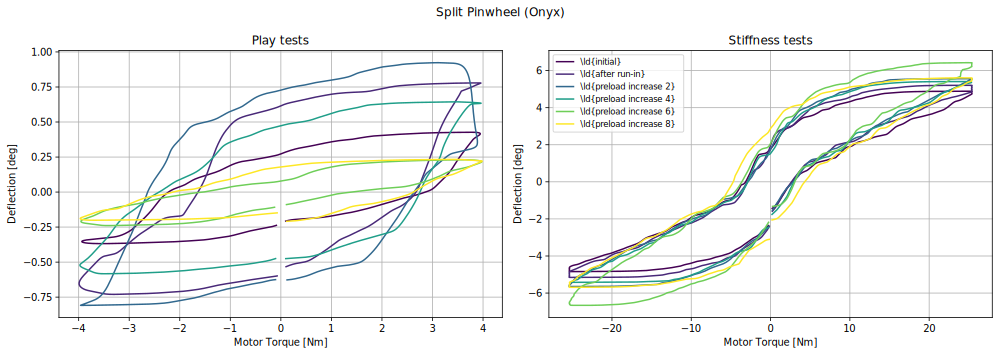

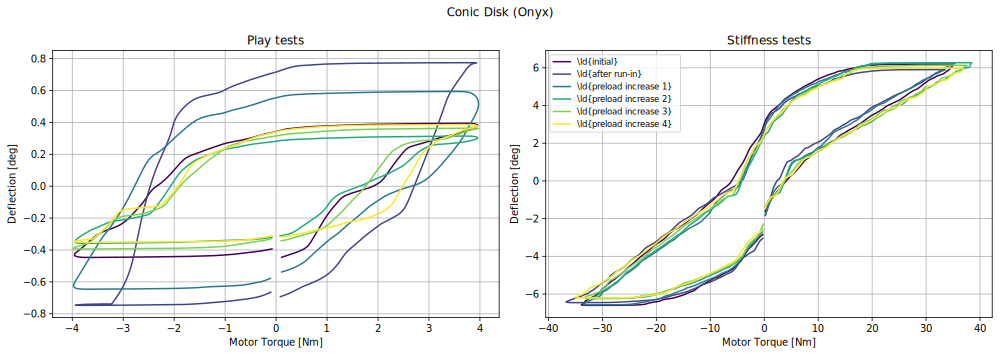

In [29]:
## unused: tests_split_pccf_u,, tests_base_910,  tests_base_pccf, tests_conic_pccf, tests_split_pccf,
actuators = [tests_base_onyx, tests_split_onyx, tests_conic_onyx]

ignored_moments = {
    tests_split_onyx.configuration: ['preload increase 1', 'preload increase 3', 'preload increase 5', 'preload increase 7']
}

def estimate_play_and_stiffness(play_test, stiffness_test):
    def get_rising_slopes(df):
        # split data in to positive and negative slopes. remove the hysteresis part
        max_torque_idx = df['Desired Torque [Nm]'].idxmax()
        pos_slope = df.loc[:max_torque_idx]

        # find zero crossing of desired torque
        min_torque_idx = df['Desired Torque [Nm]'].idxmin()
        zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
        neg_slope = df.loc[zero_torque_idx:min_torque_idx]

        return pos_slope, neg_slope

    # estimate play
    play_pos_slope, play_neg_slope = get_rising_slopes(play_test)
    pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
    neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
    play = neg_play - pos_play
    # print(f'Play: {play} deg ({pos_play} pos, {neg_play} neg)')

    # estimate stiffness
    stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(stiffness_test)
    stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > neg_play]
    stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] < pos_play]

    # do polyfit
    pos_compliance, pos_offset = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
    neg_compliance, neg_offset = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

    pos_stiffness = 1 / pos_compliance
    neg_stiffness = 1 / neg_compliance

    # print(f'Positive stiffness: {pos_stiffness} Nm/deg, offset: {pos_offset} deg')
    # print(f'Negative stiffness: {neg_stiffness} Nm/deg, offset: {neg_offset} deg')

    results = {
        'Play [deg]': play,
        'Stiffness [Nm/deg]': (pos_stiffness + neg_stiffness) / 2,
        'pos_stiffness': pos_stiffness,
        'neg_stiffness': neg_stiffness,
    }
    return results

def estimate_friction(df):
    MIN_SPEED = 0.15
    MAX_SPEED = 0.4
    
    pos_df = df[df['Motor Speed [rpm]'] > MIN_SPEED]
    neg_df = df[df['Motor Speed [rpm]'] < -MIN_SPEED]

    pos_df = pos_df[pos_df['Motor Speed [rpm]'] < MAX_SPEED]
    neg_df = neg_df[neg_df['Motor Speed [rpm]'] > -MAX_SPEED]



    pos_coulomb = pos_df['Motor Torque [Nm]'].mean()
    neg_coulomb = neg_df['Motor Torque [Nm]'].mean()
    coulomb = (pos_coulomb - neg_coulomb) / 2

    results = {
        'Coulomb Friction [Nm]': coulomb,
        'coulomb_neg': neg_coulomb,
        'coulomb_pos': pos_coulomb,
    }
    return results


# create resuls dataframe
results_df = pd.DataFrame()
for i, actuator in enumerate(actuators):
    results_dict = {}
    # print(f'\nActuator: {actuator.configuration}')

    # itterate torque ramps
    for j, (name, ramps) in enumerate(actuator.torque_ramps.items()):
        # print(f'  Test: {name}')
        for k, (play_test, stiffness_test) in ramps.items():       
            torque_results = estimate_play_and_stiffness(play_test, stiffness_test)
            results = {'actuator': actuator.configuration, 'moment': name, 'test_nr': k, **torque_results}
            results_dict[name] = {**results, **results_dict.get(name, {})}
            # print(f'    Test {k:8}: \t', ',\t '.join([f'{k}:{v:7.3f}' for k, v in torque_results.items()]))

    # itterate speed ramps
    # print(f'  Speed ramps')
    for j, (name, df) in enumerate(actuator.speed_ramps.items()):
        fric_results = estimate_friction(df)
        speed_results = {'actuator': actuator.configuration, 'test': name, **fric_results}
        results = {'actuator': actuator.configuration, 'moment': name, **speed_results}
        results_dict[name] = {**results, **results_dict.get(name, {})}
        # print(f'    {name:20}: \t', ',\t '.join([f'{k}:{v:7.3f}' for k, v in fric_results.items()]))



    results_df = pd.concat([results_df, pd.DataFrame(results_dict).T])



################ plot friction bar plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_title('Friction models')

num_tests = sum([len(actuator.speed_ramps) for actuator in actuators])
num_bars = num_tests + len(actuators) - 1
bar_width = 0.8  # Adjust bar width for visibility within groups
bar_pos = num_bars
labels = []
colors = plt.cm.viridis(np.linspace(0, 1, len(actuators)))
for i, actuator in enumerate(actuators):
    for j, (name, df) in enumerate(actuator.speed_ramps.items()):
        if name in ignored_moments.get(actuator.configuration, []):
            continue

        fric_results = estimate_friction(df)

        ax.plot((-fric_results['coulomb_neg'], fric_results['coulomb_pos']), (bar_pos, bar_pos), color=colors[i], linewidth=6, alpha=0.7)
        ax.plot((fric_results['Coulomb Friction [Nm]'], fric_results['Coulomb Friction [Nm]']), (bar_pos-0.4, bar_pos+0.4), color=colors[i])
        # indicate positive/negative side
        ax.plot(fric_results['coulomb_pos'], bar_pos, '^', color='black', markersize=7)
        ax.plot(-fric_results['coulomb_neg'], bar_pos, 'v', color='black', markersize=7)

        bar_pos -= 1
        labels.append(name)
        
    if i < len(actuators) - 1:
        ax.axhline(bar_pos, color='gray', linewidth=0.8, linestyle='--')
        bar_pos -= 1
        labels.append('')


handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(actuators))]
ax.legend(handles, [f'\\ld{{{actuator.configuration}}}' for actuator in actuators], title='Actuator', loc='upper right')
ax.set_yticks(np.arange(1, len(labels)+1))
ax.set_yticklabels(reversed(labels))
# ax.set_xticks(np.arange(1.0, 12, 0.5))
ax.set_xlabel('Coulomb Friction [Nm]')

ax.grid(axis='x', linestyle='--', linewidth=0.5)

fig.tight_layout()
fig.savefig(f'figures/friction barplot.svg')
plt.show()


# plot torque-displacement for each actuator
for actuator in actuators:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(actuator.configuration)
    axs[0].set_title('Play tests')
    axs[1].set_title('Stiffness tests')
    axs[0].set_xlabel('Motor Torque [Nm]')
    axs[0].set_ylabel('Deflection [deg]')
    axs[1].set_xlabel('Motor Torque [Nm]')
    axs[1].set_ylabel('Deflection [deg]')

    colors = plt.cm.viridis(np.linspace(0, 1, len(actuator.torque_ramps)))
    for i, (name, ramps) in enumerate(actuator.torque_ramps.items()):
        if name in ignored_moments.get(actuator.configuration, []):
            continue
        (play_test_mean, stiffness_test_mean) = ramps['combined']

        axs[0].plot(play_test_mean['Motor Torque [Nm]'], play_test_mean['Deflection [deg]'], label=f'\\ld{{{name}}}', color=colors[i])
        axs[1].plot(stiffness_test_mean['Motor Torque [Nm]'], stiffness_test_mean['Deflection [deg]'], label=f'\\ld{{{name}}}', color=colors[i])

    axs[1].legend(loc='upper left')
    axs[0].grid()
    axs[1].grid()
    fig.tight_layout()

    fig.savefig(f'figures/torque-displacement of {actuator.configuration}.svg')
    plt.show()


# results_df

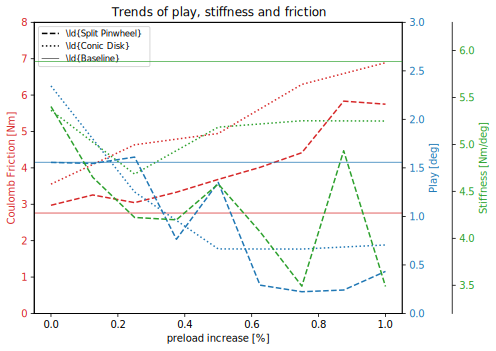

                     actuator        moment          test  \
after run-in  Baseline (Onyx)  after run-in  after run-in   

             Coulomb Friction [Nm] coulomb_neg coulomb_pos test_nr Play [deg]  \
after run-in              2.759445   -2.941621    2.577269       0   1.558115   

             Stiffness [Nm/deg] pos_stiffness neg_stiffness  
after run-in            5.88451      5.846103      5.922917  


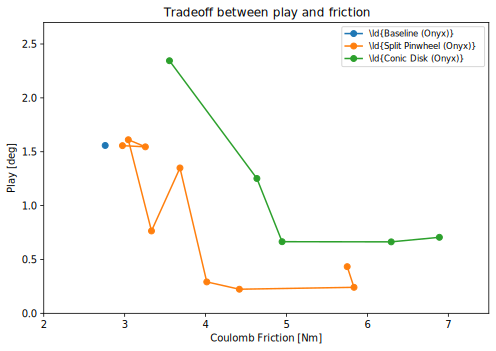

In [40]:
# plot the trends of play, stiffness and friction
actuators = [tests_base_onyx, tests_split_onyx, tests_conic_onyx]

fig, ax1 = plt.subplots(figsize=(7, 5))
colors = ['tab:red', 'tab:blue', 'tab:green']


ax1.set_ylabel('Coulomb Friction [Nm]', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel('Play [deg]', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 50))  # Offset the right spine of ax3
ax3.set_ylabel('Stiffness [Nm/deg]', color=colors[2])
ax3.tick_params(axis='y', labelcolor=colors[2])


# add baseline
actuator = actuators[0]
results = results_df[results_df['actuator'] == actuator.configuration].copy()
results = results[results['moment'] == 'after run-in'].copy()
ax1.axhline(y=results['Coulomb Friction [Nm]'].iloc[0], color=colors[0], linestyle='-', linewidth=0.7)
ax2.axhline(y=results['Play [deg]'].iloc[0], color=colors[1], linestyle='-', linewidth=0.7)
ax3.axhline(y=results['Stiffness [Nm/deg]'].iloc[0], color=colors[2], linestyle='-', linewidth=0.7)

# plot first
actuator = actuators[1]
results = results_df[results_df['actuator'] == actuator.configuration].copy()
results.drop(results[results['moment'] == 'initial'].index, inplace=True)
x_ticks = np.linspace(0, 1, len(results))

ax1.plot(x_ticks, results['Coulomb Friction [Nm]'], color=colors[0], linestyle='--', linewidth=1.5)
ax2.plot(x_ticks, results['Play [deg]'], color=colors[1], linestyle='--', linewidth=1.5)
ax3.plot(x_ticks, results['Stiffness [Nm/deg]'], color=colors[2], linestyle='--', linewidth=1.5)

# plot second
actuator = actuators[2]
results = results_df[results_df['actuator'] == actuator.configuration].copy()
results.drop(results[results['moment'] == 'initial'].index, inplace=True)
x_ticks = np.linspace(0, 1, len(results))

ax1.plot(x_ticks, results['Coulomb Friction [Nm]'], color=colors[0], linestyle=':', linewidth=1.5)
ax2.plot(x_ticks, results['Play [deg]'], color=colors[1], linestyle=':', linewidth=1.5)
ax3.plot(x_ticks, results['Stiffness [Nm/deg]'], color=colors[2], linestyle=':', linewidth=1.5)

# set limits
ax1.set_ylim(0, 8.0)
ax2.set_ylim(0, 3.0)
ax3.set_ylim(3.2, 6.3)


# Adding legends for linestyles
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linestyle='--', linewidth=1.5),
                Line2D([0], [0], color='black', linestyle=':', linewidth=1.5),
                Line2D([0], [0], color='black', linestyle='-', linewidth=0.5)]
ax1.legend(custom_lines, ['\\ld{Split Pinwheel}', '\\ld{Conic Disk}', '\\ld{Baseline}'], loc='upper left')
ax1.set_xlabel('preload increase [%]')

ax1.set_title('Trends of play, stiffness and friction')

fig.tight_layout()

fig.savefig(f'figures/play_friction trends.svg')
plt.show()


# show a pareto front of play and friction
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_title('Pareto front of play and friction')
ax.set_xlabel('Coulomb Friction [Nm]')
ax.set_ylabel('Play [deg]')


actuator = actuators[0]
results = results_df[results_df['actuator'] == actuator.configuration].copy()
results = results[results['moment'] == 'after run-in'].copy()
print(results)
ax.plot(results['Coulomb Friction [Nm]'], results['Play [deg]'], 'o-', label=f'\\ld{{{actuator.configuration}}}')

for actuator in actuators[1:]:
    results = results_df[results_df['actuator'] == actuator.configuration].copy()
    results.drop(results[results['moment'] == 'initial'].index, inplace=True)
    ax.plot(results['Coulomb Friction [Nm]'], results['Play [deg]'], 'o-', label=f'\\ld{{{actuator.configuration}}}')

ax.set_xlim(2.0, 7.5)
ax.set_ylim(0, 2.7)

ax.set_title('Tradeoff between play and friction')

ax.legend()
fig.tight_layout()
fig.savefig(f'figures/play_friction pareto front.svg')
plt.show()


# data averaging example

Torque ramp repeats a torque increase in alternating diction for multiple itterations. THe following is how those repetitions are averaged into a single curve

In [31]:
# select one of the raw dfs to be plotted here
df = tests_conic_onyx.raw_torque_ramps['preload increase 4']

def average_data(df):
    data = []
    grouped = df.groupby('test_nr')

    for name, group in grouped:
        group = group.drop('test_nr', axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.5ms').mean()
        group = group.interpolate(method='time')
        print(f'test {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop('test_nr')
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df

TEST_NR_OFFSET = 100
play_tests = df[df['test_nr'] < TEST_NR_OFFSET].copy()
stiffness_tests = df[df['test_nr'] >= TEST_NR_OFFSET].copy()
stiffness_tests['test_nr'] = stiffness_tests['test_nr'] - TEST_NR_OFFSET

play_test_mean = average_data(play_tests)
stiffness_test_mean = average_data(stiffness_tests)


# plot torque ramp curves for each test, then overlay mean
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# colors = plt.cm.cividis(np.linspace(0, 1, play_tests['test_nr'].max() + 2))
colors = plt.cm.viridis(np.linspace(0, 1, play_tests['test_nr'].max() + 1))

for i in range(play_tests['test_nr'].max() + 1):
    test = play_tests[play_tests['test_nr'] == i]
    color = np.array([colors[i]])
    axs[0].scatter(test['Motor Torque [Nm]'], test['Deflection [deg]'], label=f'\\ld{{test {i+1}}}', color=color, alpha=0.6, s=4)
color = np.array([colors[-1]])
axs[0].plot(play_test_mean['Motor Torque [Nm]'], play_test_mean['Deflection [deg]'], label='\\ld{mean}', color='red')
axs[0].set_title('Play tests')

for i in range(stiffness_tests['test_nr'].max() + 1):
    test = stiffness_tests[stiffness_tests['test_nr'] == i]
    color = np.array([colors[i]]) 
    axs[1].scatter(test['Motor Torque [Nm]'], test['Deflection [deg]'], label=f'\\ld{{test {i+1}}}', color=color, alpha=0.6, s=4)
color = np.array([colors[-1]]) 
axs[1].plot(stiffness_test_mean['Motor Torque [Nm]'], stiffness_test_mean['Deflection [deg]'], label='\\ld{mean}', color='red')
axs[1].set_title('Stiffness tests')


axs[0].set_xlabel('Motor Torque [Nm]')
axs[0].set_ylabel('Deflection [deg]')
axs[1].set_xlabel('Motor Torque [Nm]')
axs[1].set_ylabel('Deflection [deg]')


axs[0].legend()
axs[1].legend()


# save plot
fig.tight_layout()

fig.savefig(f'figures/torq-displacement averaging.svg')

plt.show()

test 0 resampled from 1624 to 8127 samples
test 1 resampled from 1694 to 8125 samples
test 2 resampled from 1561 to 8127 samples
test 3 resampled from 1628 to 8125 samples
test 4 resampled from 1686 to 8127 samples
setting everything to 8125 samples
test 0 resampled from 8106 to 40093 samples
test 1 resampled from 7799 to 40127 samples
test 2 resampled from 8112 to 40157 samples
setting everything to 40093 samples


# play and stiffness calculations

Play: 0.7057056345258439 deg (-0.35130501544663983 pos, 0.3544006190792041 neg)
Positive stiffness: 0.18044774478584918 Nm/deg, offset: -0.3745476471917259 deg
Negative stiffness: 0.20177623705548853 Nm/deg, offset: 0.8329684643870185 deg


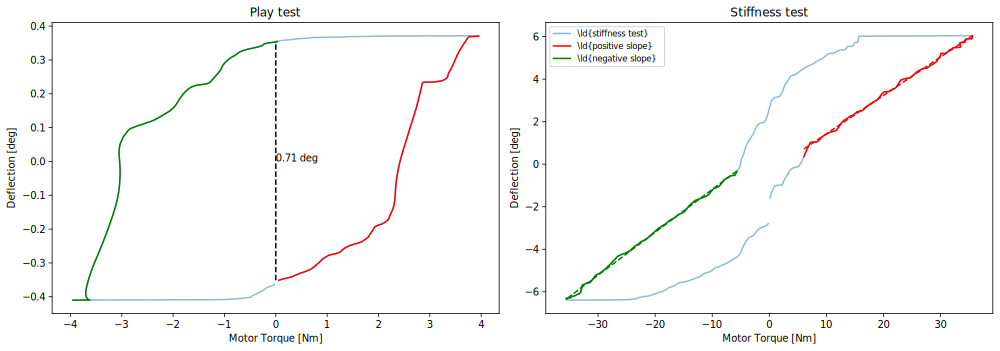

In [32]:
play_test_mean, stiffness_test_mean = tests_conic_onyx.torque_ramps['preload increase 4'][0] #['combined']

def get_rising_slopes(df):
    # split data in to positive and negative slopes. remove the hysteresis part
    max_torque_idx = df['Desired Torque [Nm]'].idxmax()
    pos_slope = df.loc[:max_torque_idx]

    # find zero crossing of desired torque
    min_torque_idx = df['Desired Torque [Nm]'].idxmin()
    zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
    neg_slope = df.loc[zero_torque_idx:min_torque_idx]

    return pos_slope, neg_slope


# estimate play
play_pos_slope, play_neg_slope = get_rising_slopes(play_test_mean)
pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
print(f'Play: {neg_play-pos_play} deg ({pos_play} pos, {neg_play} neg)')


# estimate stiffness
stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(stiffness_test_mean)
stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > neg_play]
stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] < pos_play]

# do polyfit
pos_stifness, pos_offset = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
neg_stifness, neg_offset  = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

print(f'Positive stiffness: {pos_stifness} Nm/deg, offset: {pos_offset} deg')
print(f'Negative stiffness: {neg_stifness} Nm/deg, offset: {neg_offset} deg')


fig, axs = plt.subplots(1, 2, figsize=(14, 5))
play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='\\ld{play test}', alpha=0.5)
play_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='\\ld{positive slope}', color='r')
play_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='\\ld{negative slope}', color='g')
# add line to show play
axs[0].plot([0, 0], [pos_play, neg_play], color='black', linestyle='--')
axs[0].text(0, 0, f'  {neg_play-pos_play:.2f} deg', color='black')
axs[0].set_title('Play test')

stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='\\ld{stiffness test}', alpha=0.5)
stiffness_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='\\ld{positive slope}', color='r')
stiffness_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='\\ld{negative slope}', color='g')
axs[1].plot(stiffness_pos_slope['Motor Torque [Nm]'], pos_offset + pos_stifness*stiffness_pos_slope['Motor Torque [Nm]'], color='r', linestyle='--')
axs[1].plot(stiffness_neg_slope['Motor Torque [Nm]'], neg_offset + neg_stifness*stiffness_neg_slope['Motor Torque [Nm]'], color='g', linestyle='--')
axs[1].set_title('Stiffness test')

axs[0].set_ylabel('Deflection [deg]')
axs[1].set_ylabel('Deflection [deg]')

axs[0].legend().set_visible(False)
axs[1].legend()

fig.tight_layout()
fig.savefig(f'figures/play and stiffness estimation.svg')
plt.show()



# coulomb and viscous friction coefficient calculations

In [33]:

# def estimate_friction(df):
#     # split data in positive and negative velocity
#     positive_vt = df[df['Motor Speed [rpm]'] > 0]
#     negative_vt = df[df['Motor Speed [rpm]'] < 0]

#     # fit linear model
#     pos_viscous, pos_coulomb,  = np.polyfit(positive_vt['Motor Speed [rpm]'], positive_vt['Motor Torque [Nm]'], 1)
#     neg_viscous, neg_coulomb,  = np.polyfit(negative_vt['Motor Speed [rpm]'], negative_vt['Motor Torque [Nm]'], 1)

#     # average
#     coulomb = (pos_coulomb - neg_coulomb) / 2
#     viscous = (pos_viscous + neg_viscous) / 2
#     print(f'coulomb: {coulomb:.5f}[Nm], ({pos_coulomb:.5f}, {neg_coulomb:.5f})')
#     print(f'viscous: {viscous:.5f} [Nm/(rev/s)], ({pos_viscous:.5f}, {neg_viscous:.5f})')

#     #create model lines for pos and neg seperately
#     pos_model = positive_vt.copy()
#     pos_model['Friction Model'] = pos_viscous * pos_model['Motor Speed [rpm]'] + pos_coulomb
#     neg_model = negative_vt.copy()
#     neg_model['Friction Model'] = neg_viscous * neg_model['Motor Speed [rpm]'] + neg_coulomb

#     # combine the two models
#     fric_model = pd.concat([neg_model, pos_model])

#     return fric_model

# def average_data(df, groupby):
#     data = []
#     grouped = df.groupby(groupby)

#     for name, group in grouped:
#         group = group.drop(groupby, axis=1)
#         group.index = group.index - group.index[0]

#         old_len = len(group)
#         group = group.resample('0.1ms').mean()
#         group = group.interpolate(method='time')
#         print(f'group {name} resampled from {old_len} to {len(group)} samples')

#         data.append(group.values)

#         if len(data) > 100:
#             break

#     data = data[5:100]

#     # get consistent length
#     min_len = min([len(d) for d in data])
#     data = [d[:min_len] for d in data]
#     print(f'setting everything to {min_len} samples')

#     # average data using numpy
#     data_mean = np.mean(np.array(data), axis=0)

#     new_columns = df.columns.drop(groupby)
#     mean_df = pd.DataFrame(data_mean, columns=new_columns)

#     # smooth data
#     mean_df = mean_df.rolling(window=100, center=True).mean()
#     mean_df = mean_df.bfill().ffill()

#     return mean_df


# df = tests_split_pccf.speed_ramps['initial']

# # plot measurements
# fig, axs = plt.subplots(1, 1, figsize=(14, 5))
# axs = [axs]

# df.plot(x='Motor Speed [rpm]', y='Motor Torque [Nm]', kind='scatter', alpha=0.17, ax=axs[0])
# df.plot(x='Motor Speed [rpm]', y='Averaged Torque [Nm]', kind='scatter', color='red', ax=axs[0], s=1)

# # plot estimated friction
# print(f'Estimated friction for :')
# fric_model = estimate_friction(df)
# fric_model.plot(x='Motor Speed [rpm]', y='Friction Model', color='green', ax=axs[0])

# # # plot torque over position 
# # df['REVOLUTIONS'] = np.floor(df['POSITION'])
# # df['POSITION'] = df['POSITION'] - df['REVOLUTIONS']

# # n_plots = int(df['REVOLUTIONS'].max())
# # colors = plt.cm.viridis(np.linspace(0, 1, n_plots))
# # for i in range(0, n_plots):
# #     rev = df[(df['REVOLUTIONS'] == i) & (df['Motor Speed [rpm]'] > 0)]
# #     rev.plot(x='POSITION', y='Motor Torque [Nm]', ax=axs[1], color=colors[i], alpha=0.4, legend=False)

# # avg_fric = average_data(df, 'REVOLUTIONS')
# # avg_fric.plot(x='POSITION', y='Motor Torque [Nm]', color='red', ax=axs[1])

# fig.suptitle('Friction estimation')
# fig.tight_layout()

# fig.savefig(f'figures/friction estimation.svg')
    
# plt.show()

averaging of multiple locking positions example with intermediate results

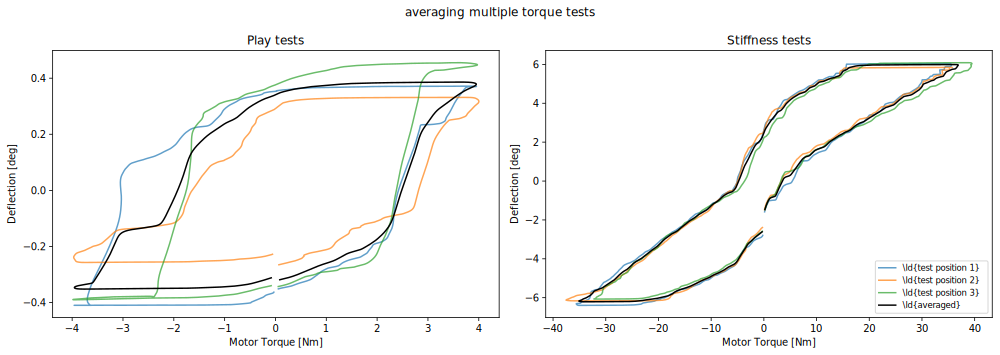

In [34]:
selected_test = tests_conic_onyx.torque_ramps['preload increase 4']

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for name, (play_test, stiffness_test) in selected_test.items():
    if name == 'combined':
        a = 1
        color = 'black'
        label = '\\ld{averaged}'
    else:
        a = 0.7
        color = None
        label = f'\\ld{{test position {name+1}}}'
    play_test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label=label, alpha=a, color=color)
    stiffness_test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label=label, alpha=a, color=color)

fig.suptitle('averaging multiple torque tests')
axs[0].set_title('Play tests')
axs[1].set_title('Stiffness tests')
axs[0].set_ylabel('Deflection [deg]')
axs[1].set_ylabel('Deflection [deg]')

axs[0].legend().set_visible(False)
axs[1].legend(loc='lower right')

fig.tight_layout()
fig.savefig(f'figures/averaging multiple torque tests.svg')
plt.show()

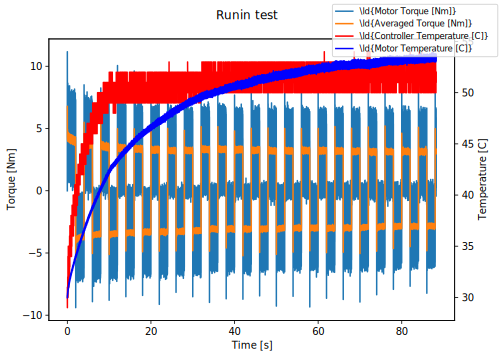

In [35]:
# plot runin test as example
df = tests_split_onyx.runin_tests
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

x_values = df.index.total_seconds() / 60

ax.plot(x_values, df['Motor Torque [Nm]'], label='\\ld{Motor Torque [Nm]}')
ax.plot(x_values, df['Averaged Torque [Nm]'], label='\\ld{Averaged Torque [Nm]}')
ax.set_ylabel('Torque [Nm]')
ax.set_xlabel('Time [s]')

# # Formatting the x-axis labels to hour:minute format
# hour_minute_formatter = mdates.DateFormatter('%H:%M')
# ax.xaxis.set_major_formatter(hour_minute_formatter)

# temperatures
ax2 = ax.twinx()
ax2.plot(x_values, df['Controller Temperature [c]'], color='red', label='\\ld{Controller Temperature [C]}')
ax2.plot(x_values, df['Motor Temperature [c]'], color='blue', label='\\ld{Motor Temperature [C]}')
ax2.set_ylabel('Temperature [C]')

#speed
# ax3 = ax.twinx()
# ax3.spines['right'].set_position(('outward', 50))  # Offset the right spine of ax3
# ax3.plot(df['Motor Speed [rpm]'], color='red', label='\\ld{Motor Speed [rpm]}')

fig.suptitle('Runin test')
fig.legend(loc='upper right')


fig.tight_layout()
fig.savefig(f'figures/runin test.svg')

plt.show()
        